In [ ]:
# default_exp core

In [ ]:
#hide
import sys
sys.path.append("/home/austin/workspace/sensorai")

In [ ]:
from PIL import Image

In [ ]:
#export
from sensorai.imports import *
from sensorai.tf_imports import *

In [ ]:
#hide
from nbdev.showdoc import *

# TensorFlow Core
> Basic tensorflow functions used in the waveai library

## 1% Better Everyday

- [x] Read [Make Delegation Work in Python](https://www.fast.ai/2019/08/06/delegation/) to understand what is `@delegates` is used for.

## Arrays and show

In [ ]:
#export
@delegates(plt.subplots, keep=True)
def subplots(nrows=1, ncols=1, figsize=None, imsize=3, suptitle=None, **kwargs):
    if figsize is None:
        h = nrows*imsize if suptitle is None or imsize>2 else nrows*imsize+0.6 #https://github.com/matplotlib/matplotlib/issues/5355
        figsize = (ncols*imsize, h)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = array([ax])
    return fig,ax

In [ ]:
#hide
_,axs = subplots()
test_eq(axs.shape,[1,])
plt.close()

_,axs = subplots(2,3)
test_eq(axs.shape,[2,3])
plt.close()

In [ ]:
#export
def _fig_bounds(x):
    r = x//32
    return min(5, max(1,r))

In [ ]:
#export
@delegates(plt.Axes.imshow, keep=True, but=['shape', 'imlim'])
def show_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    # Handle pytorch axis order
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]

    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

`show_image` can show PIL images

In [ ]:
TEST_IMAGE = 'images/wave.png'

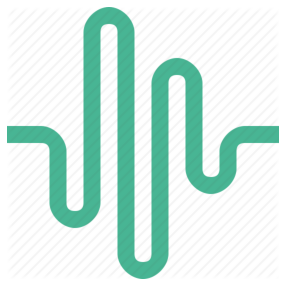

In [ ]:
im = Image.open(TEST_IMAGE)
ax = show_image(im, cmap="Greys")

and color images with order

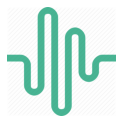

In [ ]:
im2 = np.array(Image.open(TEST_IMAGE))
ax = show_image(im2, figsize=(2,2))

and color imags with order

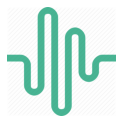

In [ ]:
im3 = tf.convert_to_tensor(im2)
ax = show_image(im3, figsize=(2,2))

In [ ]:
#export
@delegates(show_image, keep=True)
def show_titled_image(o, **kwargs):
    "Call `show_image` destructuring `o` to `(img, title)`"
    show_image(o[0], title=str(o[1]), **kwargs)

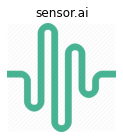

In [ ]:
show_titled_image((im3, 'sensor.ai'), figsize=(2,2))

Show all images ims as subplots with rows using titles. suptitle provides a way to create a figure title for all images. If you use suptitle, constrained_layout is used unless you set constrained_layout to False

In [ ]:
#export
@delegates(subplots)
def show_images(ims, nrows=1, ncols=None, titles=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`."
    if ncols is None: ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: titles = [None]*len(ims)
    axs = subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t)

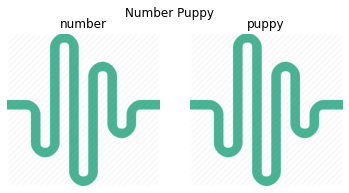

In [ ]:
show_images((im,im3), titles=('number','puppy'), suptitle='Number Puppy', imsize=3)

`ArrayImage`, `ArrayImageBW` and `ArrayMask` are subclasses of `ndarray` that know how to show themselves.

## Basics

## Reproducibility

[How can I obtain reproducible results using Keras during development?](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)

[Keras - Python Deep Learning Neural Network API](https://deeplizard.com/learn/video/HcW0DeWRggs)

`set_seed` is useful for reproducibility between runs. It is important to remember that certain classes such as `tf.data.Dataset` have internal random number generators that is not effected by this function, so this must be run before such objects are created in order to guarantee reproducibility.

In [ ]:
#export
def set_seed(s, reproducible=False):
    "Set random seed for `random`, `tf`, and `numpy` (where available)"
    try: tf.random.set_seed(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        os.environ['PYTHONHASHSEED'] = str(seed)
        os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
set_seed(2*33)
a1 = np.random.random()
a2 = tf.random.uniform(())
a3 = random.random()
set_seed(2*33)
b1 = np.random.random()
b2 = tf.random.uniform(())
b3 = random.random()
print('a\'s: {0:3.3f} {1:3.3f} {2:3.3f}'.format(a1,a2,a3))
print('b\'s: {0:3.3f} {1:3.3f} {2:3.3f}'.format(b1,b2,a3))

a's: 0.154 0.969 0.071
b's: 0.154 0.969 0.071


In [ ]:
test_eq(a1,b1)
test_eq(a2.numpy(),b2.numpy())
test_eq(a3,b3)

`get_random_states` and `set_random_states` are useful for storing a state so you can go back to it later.

> Warning: `tf.random` does not support to read the seed from the internal state. 

In [ ]:
#export
def get_random_states():
    "Gets states for `random`, `numpy` and `tensorflow` random number generators"
    return {'random_state': random.getstate(),
            'numpy_state' : np.random.get_state()}

In [ ]:
#export
def set_random_states(random_state, numpy_state):
    "Set states for `random`, `numpy` and `tensorflow` random number generators"
    random.setstate(random_state)
    np.random.set_state(numpy_state)

Below notice that the old values and rewinded values are the same because we were able to return to the previous state.

In [ ]:
old_states = get_random_states()
olds = (random.random(),np.random.random())
news = (random.random(),np.random.random())
set_random_states(**old_states)
rewinds = (random.random(),np.random.random())

print('olds:    {0:3.3f} {1:3.3f}'.format(*olds))
print('news:    {0:3.3f} {1:3.3f}'.format(*news))
print('rewinds: {0:3.3f} {1:3.3f}'.format(*rewinds))

olds:    0.435 0.134
news:    0.246 0.363
rewinds: 0.435 0.134
